In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline


### import class wrapper

from classy import Class

### math stuff
import numpy as np
from scipy.optimize import fsolve

### Controlling iteration speed

from tqdm.notebook import trange, tqdm 

### plotting stuff
import matplotlib.pyplot as plt
#import matplotlib.ticker as mticker
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import cmasher as cmr
import matplotlib.patheffects as pe
import matplotlib.ticker as ticker
#import pandas as pd 

In [2]:
### INPUT ###
Omega_scf=1e-4 #scalar field density parameter at present, can be whatever as it's recomputed anyway, but needs to be sth for CLASS to realize there's scalar field.
#kvec = np.logspace(-4,np.log10(3),1000)
k_values = [1e-3, 1e-2, 1e-1, 1]
# k_values = [1e-5, 1e-4, 1e-3, 1e-2]
### Turn k_values into a string '1e-3, 1e-2, 1e-1, 1' for input to CLASS
k_values_CLASS = ', '.join([str(k) for k in k_values])
###
common_settings = {
                    'output': 'tCl,pCl,lCl,mPk',
                    'k_output_values': k_values_CLASS,
                    'lensing': 'yes',
                    'P_k_max_h/Mpc': 10, 
                    # LambdaCDM parameters
                   'h': 0.67810,
                   'omega_b': 0.02238280 ,
                   'Omega_cdm': 0.27,
                   'Omega_scf': Omega_scf,
                   'Omega_Lambda': 0.70,
                   'Omega_k': 0,
                   'gauge': 'new', 
                   ### let's add some massive neutrinos
                   'N_ur': 0,
                   'N_ncdm': 1, 
                   'deg_ncdm': 3,
                   'm_ncdm': 0.02, #eV
                    'T_ncdm': 0.71611,
                   }  

no_scalar = { 
                  'output': 'tCl,pCl,lCl,mPk, dTk',
                  'k_output_values': k_values_CLASS,
                  'lensing': 'yes',
                  'P_k_max_h/Mpc': 10, 
                  # LambdaCDM parameters
                  'h': 0.67810,
                  'omega_b': 0.02238280,
                  'Omega_cdm': 0.27,
                  #'Omega_Lambda': 0.7,
                  'Omega_k': 0.,
                  'Omega_scf': 0.,
                  'Omega_fld': 0., 
                  'gauge': 'new', 
                  'beta': 0.0, 
                   }  

In [ ]:
### Run CLASS ###
ScalarCLASS = {}
beta_lrm = [0.005, 0.02]
s_ini_factor = [0, 1e2, 1e4, 1e6, 1e8]
s_ini = 1e-4
for beta in beta_lrm:
    phi_prime_ini = 1e15 # WIP, just a rescaling of actual initial value
    print(f'Running CLASS for beta = {beta} and phi_ini = {np.sqrt(beta/2)**(-1)*s_ini}, phi_prime_ini = {phi_prime_ini}') 
    ScalarCLASS[beta] = Class()
    ScalarCLASS[beta].set(common_settings)
    ScalarCLASS[beta].set({
                    'scf_parameters': f'0.0, 0.1, 0.0, 0.0, {s_ini}, {phi_prime_ini}',
                    'attractor_ic_scf': 'no',
                    'beta': beta,
                    # 'beta_lrm_2': 0, 
                    })
    ScalarCLASS[beta].compute()
    
# Initialize dictionaries for background and perturbation quantities
bgScalar, pbScalar = {}, {}
z, a, H = {}, {}, {}
phi_scf, dphi_scf, V_scf = {}, {}, {}
delta_cdm, theta_cdm, delta_g, delta_scf, delta_b = {}, {}, {}, {}, {}
delta_m = {}
#theta_cdm, psi, phi = {}, {}, {}
rho_g, rho_cdm, rho_b, rho_ur, rho_scf, rho_lambda = {}, {}, {}, {}, {}, {}
rho_ncdm = {}
frac_chi = {}
rho_tot, rho_crit = {}, {}
p_scf, comov = {}, {}
# Initialize dictionaries for power spectrum
ll, clTT, clEE, clTE, clPP = {}, {}, {}, {}, {}

# Loop over each beta value and extract necessary background and perturbation data
for beta in beta_lrm:
    ### BACKGROUND
    bgScalar = ScalarCLASS[beta].get_background()
    thScalar = ScalarCLASS[beta].get_thermodynamics()
    print(bgScalar.keys())
    #print(ScalarCLASS[beta].h())

    # Extract some background cosmological quantities
    H[beta] = bgScalar['H [1/Mpc]']
    z[beta] = bgScalar['z']
    comov[beta] = bgScalar['comov. dist.']

    # Extract energy densities for non-scalar components
    rho_g[beta] = bgScalar['(.)rho_g']
    rho_b[beta] = bgScalar['(.)rho_b']
    rho_cdm[beta] = bgScalar['(.)rho_cdm']
    
    frac_chi[beta] = rho_cdm[beta] / (rho_cdm[beta] + rho_b[beta])
    
    rho_lambda[beta] = bgScalar['(.)rho_lambda']
    #rho_ur[beta] = bgScalar['(.)rho_ur']
    rho_ur[beta] = bgScalar['(.)rho_ncdm[0]']
    rho_tot[beta] = bgScalar['(.)rho_tot']
    rho_crit[beta] = bgScalar['(.)rho_crit']
    
    # Extract scalar field quantities
    phi_scf[beta] = bgScalar['phi_scf']
    dphi_scf[beta] = bgScalar["phi'_scf"]
    V_scf[beta] = bgScalar['V_scf']
    rho_scf[beta] = bgScalar['(.)rho_scf']
    p_scf[beta] = bgScalar['(.)p_scf']
    
    ### PERTURBATIONS
    pbScalar = ScalarCLASS[beta].get_perturbations()
    for i in range(len(k_values)):
        scalar_data = pbScalar['scalar'][i]  # Scalar perturbations for selected k-values
        a[beta, k_values[i]] = scalar_data['a']
        
        # Extract perturbation quantities
        delta_cdm[beta, k_values[i]] = scalar_data['delta_cdm']
        delta_g[beta, k_values[i]] = scalar_data['delta_g']
        delta_scf[beta, k_values[i]] = scalar_data['delta_scf']
        delta_b[beta, k_values[i]] = scalar_data['delta_b']
        frac_chi_interp = np.interp(a[beta, k_values[i]], 1/(1+z[beta]), frac_chi[beta])
        delta_m[beta, k_values[i]] = frac_chi_interp*delta_cdm[beta, k_values[i]] + (1-frac_chi_interp)*delta_b[beta, k_values[i]]
        theta_cdm[beta, k_values[i]] = scalar_data['theta_cdm']
        # psi[beta] = scalar_data['psi']
        # phi[beta] = scalar_data['phi']
        
    ### POWER SPECTRUM
    
    clScalar = ScalarCLASS[beta].lensed_cl(2500)
    ll[beta] = clScalar['ell'][2:]
    clTT[beta] = clScalar['tt'][2:]
    clEE[beta] = clScalar['ee'][2:]
    clTE[beta] = clScalar['te'][2:]
    clPP[beta] = clScalar['pp'][2:]
        


Running CLASS for beta = 0.005 and phi_ini = 0.002, phi_prime_ini = 1
[Iter 0] Omega0_lambda = 6.878335429324506e-01 (change = 1.688e+00)
Running CLASS for beta = 0.02 and phi_ini = 0.001, phi_prime_ini = 1
[Iter 0] Omega0_lambda = 7.167376464874070e-01 (change = 1.717e+00)
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_lambda', '(.)rho_crit', '(.)rho_scf', '(.)p_scf', '(.)p_prime_scf', 'phi_scf', "phi'_scf", 'V_scf', "V'_scf", "V''_scf", '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_lambda', '(.)rho_crit', '(.)rho_scf', '(.)p_scf', '(.)p_prime_scf', 'phi_scf', "phi'_scf", 'V_scf', "

In [4]:
LCDM = Class()
LCDM.set(no_scalar)
LCDM.compute()

# Load LCDM background and perturbation data
bgLCDM = LCDM.get_background()
pbLCDM = LCDM.get_perturbations()

# Extract LCDM background and perturbation quantities
z_lcdm = bgLCDM['z']
H_lcdm = bgLCDM['H [1/Mpc]']
rho_cdm_lcdm = bgLCDM['(.)rho_cdm']
rho_b_lcdm = bgLCDM['(.)rho_b']
rho_g_lcdm = bgLCDM['(.)rho_g']
rho_lambda_lcdm = bgLCDM['(.)rho_lambda']
rho_ur_lcdm = bgLCDM['(.)rho_ur']
#rho_k_lcdm = bgLCDM['(.)rho_scf']
comov_lcdm = bgLCDM['comov. dist.']

frac_cdm = rho_cdm_lcdm/(rho_cdm_lcdm + rho_b_lcdm)

delta_cdm_lcdm, delta_b_lcdm, theta_cdm_lcdm, delta_g_lcdm, a_lcdm = {}, {}, {}, {}, {}
delta_m_lcdm = {}

for i in range(len(k_values)):
    scalar_data = pbLCDM['scalar'][i]  # Scalar perturbations for selected k-values
    # Extract perturbation quantities
    a_lcdm[k_values[i]] = scalar_data['a']
    delta_cdm_lcdm[k_values[i]] = scalar_data['delta_cdm']
    theta_cdm_lcdm[k_values[i]] = scalar_data['theta_cdm']
    delta_b_lcdm[k_values[i]] = scalar_data['delta_b']
    
    frac_cdm_interp = np.interp(a_lcdm[k_values[i]], 1/(1+z_lcdm), frac_cdm)
    delta_m_lcdm[k_values[i]] = frac_cdm_interp * delta_cdm_lcdm[k_values[i]] + (1-frac_cdm_interp) * delta_b_lcdm[k_values[i]]
    
    delta_g_lcdm[k_values[i]] = scalar_data['delta_g']
    
clLCDM = LCDM.lensed_cl(2500)
ll_lcdm = clLCDM['ell'][2:]
clTT_lcdm = clLCDM['tt'][2:]
clEE_lcdm = clLCDM['ee'][2:]
clTE_lcdm = clLCDM['te'][2:]
clPP_lcdm = clLCDM['pp'][2:]
    
rho_tot_lcdm = bgLCDM['(.)rho_tot']
rho_crit_lcdm = bgLCDM['(.)rho_crit']


In [5]:
print(delta_m_lcdm.keys())

dict_keys([0.001, 0.01, 0.1, 1])


In [6]:
# Compute useful quantities for LCDM first
Omega_cdm_lcdm = rho_cdm_lcdm[-1] / rho_crit_lcdm[-1]
Omega_lambda_lcdm = rho_lambda_lcdm[-1] / rho_tot_lcdm[-1]

# Precompute delta_rho_cdm
delta_rho_cdm = (5.0960607895714815e-8 - 5.0485082894966374e-8) / rho_crit[0.02][-1]

# Header
print(f"{'Quantity':<20}", end="")
print(f"{'LCDM':>20}", end="")
for beta in beta_lrm:
    print(f"{f'beta={beta}':>20}", end="")
print()
print("-" * (20 + 20 * (len(beta_lrm) + 1)))

# Data
print(f"{'rho_tot':<20} {rho_tot_lcdm[-1]:>20.4e}", end="")
for beta in beta_lrm:
    print(f"{rho_tot[beta][-1]:>20.4e}", end="")
print()


print(f"{'rho_tot_diff':<20} {rho_tot_lcdm[-1]-rho_tot_lcdm[-1]:>20.4e}", end="")
for beta in beta_lrm:
    print(f"{(-rho_tot[beta][-1]+rho_tot_lcdm[-1]):>20.4e}", end="")
print()

print(f"{'rho_b':<20} {rho_b_lcdm[-1]:>20.4e}", end="")
for beta in beta_lrm:
    print(f"{rho_b[beta][-1]:>20.4e}", end="")
print()

print(f"{'rho_r':<20} {rho_g_lcdm[-1]+rho_ur_lcdm[-1]:>20.4e}", end="")
for beta in beta_lrm:
    print(f"{rho_g[beta][-1]+rho_ur[beta][-1]:>20.4e}", end="")
print()

print(f"{'rho_cdm':<20} {rho_cdm_lcdm[-1]:>20.4e}", end="")
for beta in beta_lrm:
    print(f"{rho_cdm[beta][-1]:>20.4e}", end="")
print()

# print(f"{'rho_cdm_computed':<20} {rho_cdm_lcdm[-1]:>20.4e}", end="")
# for beta in beta_lrm:
#     print(f"{m_chi(np.sqrt(beta/2)*phi_scf[beta][-1])/m_chi(1e-4)*rho_cdm[beta][-1]:>20.4e}", end="")
# print()

# print(f"{'Omega_chi':<20} {Omega_cdm_lcdm:>20.4e}", end="")
# for beta in beta_lrm:
#     Omega_chi_beta = m_chi(np.sqrt(beta/2)*phi_scf[beta][-1])/m_chi(1e-4)*rho_cdm[beta][-1] / rho_crit[beta][-1]
#     print(f"{(Omega_chi_beta):>20.4e}", end="")
# print()

# print(f"{'Omega_chi/Omega_cdm':<20} {Omega_cdm_lcdm/Omega_cdm_lcdm:>20.4e}", end="")
# for beta in beta_lrm:
#     Omega_chi_cdm_ratio = rho_cdm[beta][-1] / rho_crit[beta][-1] / Omega_cdm_lcdm
#     print(f"{(Omega_chi_cdm_ratio):>20.4e}", end="")
# print()

# print(f"{'m_chi_ratio':<20} {m_chi(1e-4)/m_chi(1e-4):>20.4e}", end="")
# for beta in beta_lrm:
#     print(f"{m_chi(np.sqrt(beta/2)*phi_scf[beta][-1])/m_chi(1e-4):>20.4e}", end="")
# print()

# print(f"{'rho_cdm_chi_diff':<20} {rho_cdm_lcdm[-1]:>20.4e}", end="")
# for beta in beta_lrm:
#     print(f"{rho_cdm[beta][-1]-m_chi(np.sqrt(beta/2)*phi_scf[beta][-1])/m_chi(1e-4)*rho_cdm[beta][-1]:>20.4e}", end="")
# print()

# print(f"{'Omega_cdm':<20} {Omega_cdm_lcdm:>20.4e}", end="")
# for beta in beta_lrm:
#     Omega_cdm_beta = rho_cdm[beta][-1] / rho_crit[beta][-1]
#     print(f"{(Omega_cdm_beta):>20.4e}", end="")
# print()

print(f"{'rho_scf':<20} {0:>20.4e}", end="")
for beta in beta_lrm:
    print(f"{rho_scf[beta][-1]:>20.4e}", end="")
print()

# print(f"{'Omega_scf':<20} {0:>20.4e}", end="")
# for beta in beta_lrm:
#     Omega_scf_beta = rho_scf[beta][-1] / rho_tot[beta][-1]
#     print(f"{Omega_scf_beta:>20.4e}", end="")
# print()

# print(f"{'Omega_lambda':<20} {Omega_lambda_lcdm:>20.4e}", end="")
# for beta in beta_lrm:
#     Omega_lambda_beta = rho_lambda[beta][-1] / rho_tot[beta][-1]
#     print(f"{Omega_lambda_beta:>20.4e}", end="")
# print()

print(f"{'rho_lambda':<20} {rho_lambda_lcdm[-1]:>20.4e}", end="")
for beta in beta_lrm:
    print(f"{rho_lambda[beta][-1]:>20.4e}", end="")
print()

print(f"{'Omega_lambda':<20} {rho_lambda_lcdm[-1]/rho_tot_lcdm[-1]:>20.4e}", end="")
for beta in beta_lrm:
    print(f"{(rho_scf[beta][-1]+rho_lambda[beta][-1])/rho_tot[beta][-1]:>20.4e}", end="")


# Other quantities
print("\nOther Quantities")
print("-" * (20 + 20 * (len(beta_lrm) + 1)))

print(f"{'delta_rho_cdm':<20} {delta_rho_cdm:>20.4e}")

print(f"{'Hubble (H0)':<20} {H_lcdm[-1]*3e3:>20.4e}", end="")
for beta in beta_lrm:
    print(f"{H[beta][-1]*3e3:>20.4e}", end="")
print()

print(f"{'sqrt(rho_tot)':<20} {np.sqrt(rho_tot_lcdm[-1]):>20.4e}", end="")
for beta in beta_lrm:
    print(f"{np.sqrt(rho_tot[beta][-1]):>20.4e}", end="")



Quantity                            LCDM          beta=0.005           beta=0.02
--------------------------------------------------------------------------------
rho_tot                        5.1162e-08          5.1162e-08          5.1163e-08
rho_tot_diff                   0.0000e+00          1.0784e-13         -8.6967e-13
rho_b                          2.4904e-09          2.4904e-09          2.4904e-09
rho_r                          4.6538e-12          7.4458e-11          7.4458e-11
rho_cdm                        1.3814e-08          1.3358e-08          1.1690e-08
rho_scf                        0.0000e+00          4.8074e-11          2.3779e-10
rho_lambda                     3.4853e-08          3.5191e-08          3.6670e-08
Omega_lambda                   6.8123e-01          6.8877e-01          7.2137e-01
Other Quantities
--------------------------------------------------------------------------------
delta_rho_cdm                  9.2944e-03
Hubble (H0)                    6.7857e-01 

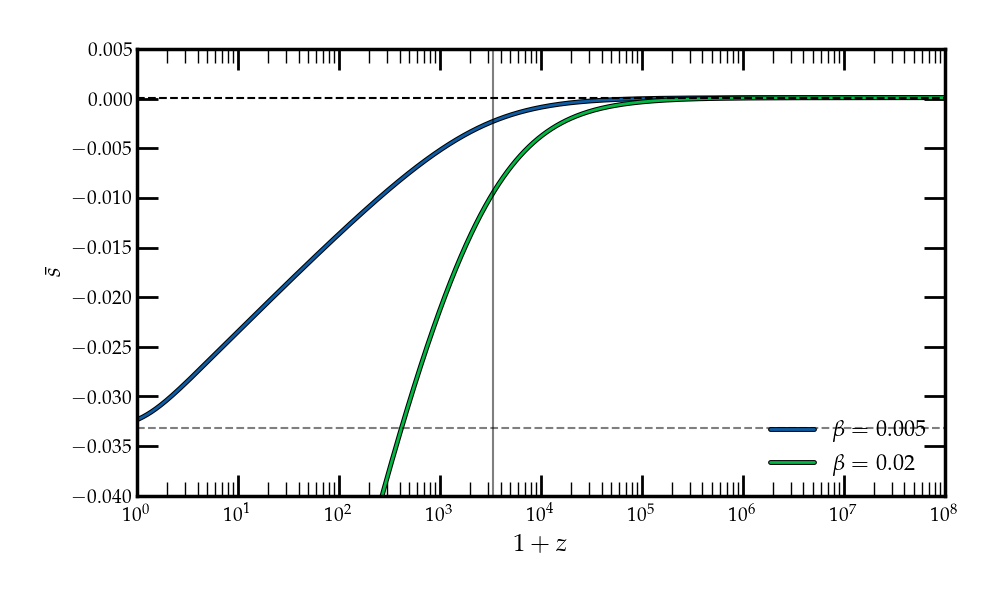

In [7]:
plt.style.use('/mnt/e/Workplace/sty.mplstyle')
%matplotlib ipympl

plt.figure(figsize=(10, 6))

# Plot each beta value except the first one
for beta in beta_lrm:
    plt.semilogx(1 + z[beta], phi_scf[beta] / np.sqrt(2 / beta), label=rf'$\beta={beta}$', linewidth=2, path_effects=[pe.withStroke(linewidth=3.5, foreground='black')])

# Axis labels
plt.xlabel(r'$1+z$', fontsize=18)
plt.ylabel(r'$\bar{s}$', fontsize=18)

# Dashed reference lines
plt.axvline(x=3400, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
plt.axhline(y=1e-4, xmin=0, xmax=1, color='black', linestyle='--', linewidth=1.5)
plt.axhline(y=-0.0332, xmin=0, xmax=1, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

# Axis limits
plt.xlim(1, 1e8)
plt.ylim(-0.04, 0.005)

# Log scale ticks and grid
#plt.grid(True, which='major', linestyle=':', linewidth=0.8)
plt.tick_params(axis='both', which='both', labelsize=14)

# Legend
plt.legend(fontsize=16, loc='lower right', frameon=False)

# Tight layout for clean spacing
plt.tight_layout()
plt.show()

/home/agomulka/.pyenv/versions/3.12.3/envs/cosmo_TH/lib/python3.12/site-packages/matplotlib/scale.py:270: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


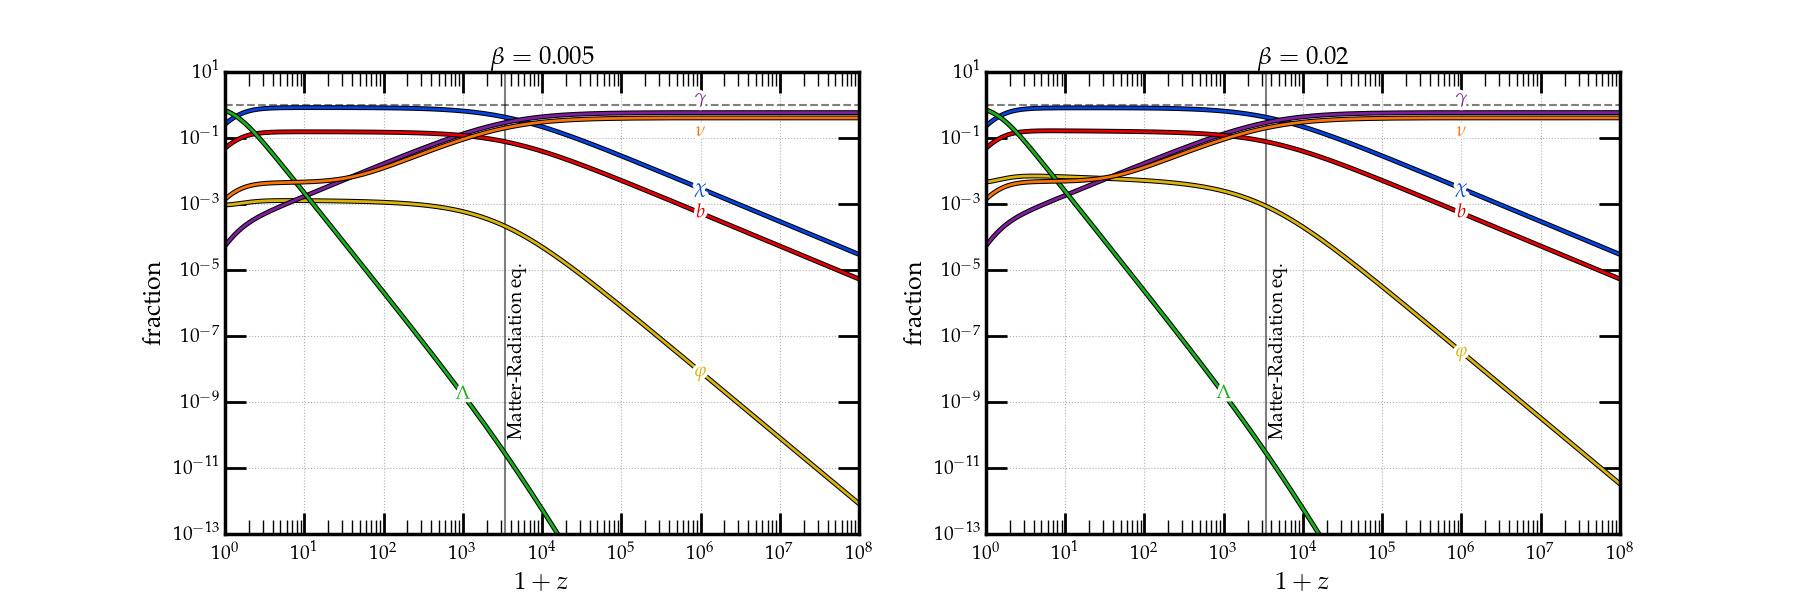

In [8]:
from labellines import labelLine, labelLines

### Make a two panel plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True)
# Plot each beta value
for ax, beta in zip((ax1, ax2), beta_lrm):
    ax.tick_params(axis='both', which='both', labelsize=14)
    ax.set_xlim(1, 1e8)
    ax.set_ylim(1e-13, 10)
    ax.set_xlabel(r'$1+z$', fontsize=18)
    ax.set_ylabel(r'fraction', fontsize=18)
    ax.set_title(rf'$\beta={beta}$', fontsize=18)
    ax.axhline(y=1, xmin=0, xmax=1e8, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.axvline(x=3400, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
    ax.text(3600, 1e-10, r'Matter-Radiation eq.', fontsize=14, rotation=90)
    ax.grid(True, which='major', linestyle=':', linewidth=0.8)
    
    ax.loglog(1 + z[beta], rho_cdm[beta] / rho_tot[beta], label=rf'$\chi$', linewidth=2, path_effects=[pe.withStroke(linewidth=3.5, foreground='black')], color='xkcd:blue')
    ax.loglog(1 + z[beta], rho_scf[beta] / rho_tot[beta], label=rf'$\varphi$', linewidth=2, path_effects=[pe.withStroke(linewidth=3.5, foreground='black')], color='xkcd:gold')
    ax.loglog(1 + z[beta], rho_g[beta] / rho_tot[beta], label=rf'$\gamma$', linewidth=2, path_effects=[pe.withStroke(linewidth=3.5, foreground='black')], color='xkcd:purple')
    ax.loglog(1 + z[beta], rho_b[beta] / rho_tot[beta], label=rf'$b$', linewidth=2, path_effects=[pe.withStroke(linewidth=3.5, foreground='black')], color='xkcd:red')
    ax.loglog(1 + z[beta], rho_lambda[beta] / rho_tot[beta], label=rf'$\Lambda$', linewidth=2, path_effects=[pe.withStroke(linewidth=3.5, foreground='black')], color='xkcd:green')
    ax.loglog(1 + z[beta], rho_ur[beta] / rho_tot[beta], label=rf'$\nu$', linewidth=2, path_effects=[pe.withStroke(linewidth=3.5, foreground='black')], color='xkcd:orange')
    
    lines = ax.get_lines()
    chi_line = lines[2]
    phi_line = lines[3]
    gamma_line = lines[4]
    b_line = lines[5]
    lambda_line = lines[6]
    nu_line = lines[7]
    
    labelLines([chi_line, phi_line, b_line, lambda_line], align=False, fontsize=14, xvals=[1e6, 1e6, 1e6, 1e3])
    #labelLines([lambda_line], align=False, fontsize=14, xvals=1e3)
    labelLines([gamma_line, nu_line], align=False, fontsize=14, xvals=[1e6, 1e6], yoffsets=[+1, -0.25])
    
    
    #labelLines(lines[2:], align=False, fontsize=14, xvals=1e6)
    
    #ax.legend(fontsize=16, loc='lower left', frameon=False)

fig.savefig('rho_fraction.pdf', dpi=300, bbox_inches='tight')


/tmp/ipykernel_80844/654813569.py:36: RuntimeWarning: invalid value encountered in divide
  axs[3].semilogx(1 + z[beta], comov[beta] / comov_lcdm_interp, linewidth=2, path_effects=[pe.withStroke(linewidth=3.5, foreground='black')], label=rf'$\beta={beta}$')


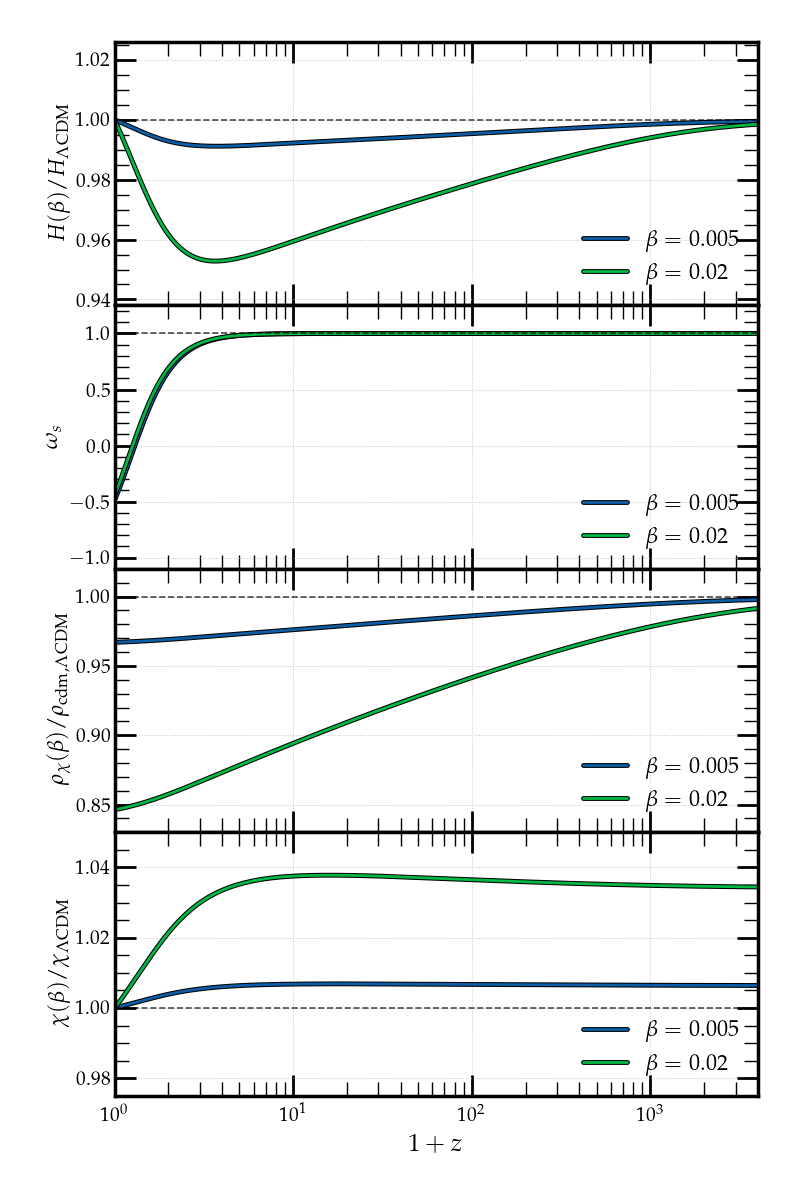

In [9]:
from scipy.interpolate import interp1d

# Set up figure
fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)

# Define colormap and normalization
norm = mcolors.LogNorm(vmin=min(beta_lrm[1:]), vmax=max(beta_lrm[1:]))
cmap = cmr.ember

# Interpolation functions
interp_H_lcdm = interp1d(z_lcdm, H_lcdm, kind='linear', bounds_error=False, fill_value='extrapolate')
interp_rho_cdm_lcdm = interp1d(z_lcdm, rho_cdm_lcdm, kind='linear', bounds_error=False, fill_value='extrapolate')
interp_comov_lcdm = interp1d(z_lcdm, comov_lcdm, kind='linear', bounds_error=False, fill_value='extrapolate')

# Loop over beta values
for beta in beta_lrm:

    # Interpolated LCDM quantities onto z[beta] grid
    H_lcdm_interp = interp_H_lcdm(z[beta])
    rho_cdm_lcdm_interp = interp_rho_cdm_lcdm(z[beta])
    comov_lcdm_interp = interp_comov_lcdm(z[beta])

    # Plot 1: H[beta] / H_lcdm
    axs[0].semilogx(1 + z[beta], H[beta] / H_lcdm_interp, linewidth=2, path_effects=[pe.withStroke(linewidth=3.5, foreground='black')], label=rf'$\beta={beta}$')
    axs[0].set_ylim(0.938, 1.026)
    
    # Plot 2: omega_scf[beta]
    axs[1].semilogx(1 + z[beta], p_scf[beta] / rho_scf[beta], linewidth=2, path_effects=[pe.withStroke(linewidth=3.5, foreground='black')], label=rf'$\beta={beta}$')
    axs[1].set_ylim(-1.1, 1.25)
    
    # Plot 3: rho_cdm[beta] / rho_cdm_lcdm
    axs[2].semilogx(1 + z[beta], rho_cdm[beta] / rho_cdm_lcdm_interp, linewidth=2, path_effects=[pe.withStroke(linewidth=3.5, foreground='black')], label=rf'$\beta={beta}$')
    axs[2].set_ylim(0.83, 1.02)
    
    # Plot 4: comov[beta] / comov_lcdm
    axs[3].semilogx(1 + z[beta], comov[beta] / comov_lcdm_interp, linewidth=2, path_effects=[pe.withStroke(linewidth=3.5, foreground='black')], label=rf'$\beta={beta}$')
    axs[3].set_ylim(0.975, 1.05)
    
# Common plot settings
titles = [
    r'$H(\beta)/H_{\Lambda\mathrm{CDM}}$',
    r'$\omega_s$',
    r'$\rho_{\chi}(\beta)/\rho_{\mathrm{cdm},\Lambda\mathrm{CDM}}$',
    r'$\chi(\beta)/\chi_{\Lambda\mathrm{CDM}}$'
]

for i, ax in enumerate(axs):
    ax.set_ylabel(titles[i], fontsize=16)
    ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=1.2, alpha=0.7)  # reference line at 1 (for ratios)
    ax.set_xlim(1, 4000)
    ax.legend(fontsize=16, loc='lower right', frameon=False)

# X-axis label only on bottom plot
axs[-1].set_xlabel(r'$1+z$', fontsize=18)

# Layout adjustments
plt.tight_layout()
plt.subplots_adjust(hspace=0.0)

plt.show()

# Save the figure
fig.savefig('beta_lrm_comparison.pdf', dpi=300, bbox_inches='tight')

/tmp/ipykernel_80844/1798232522.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


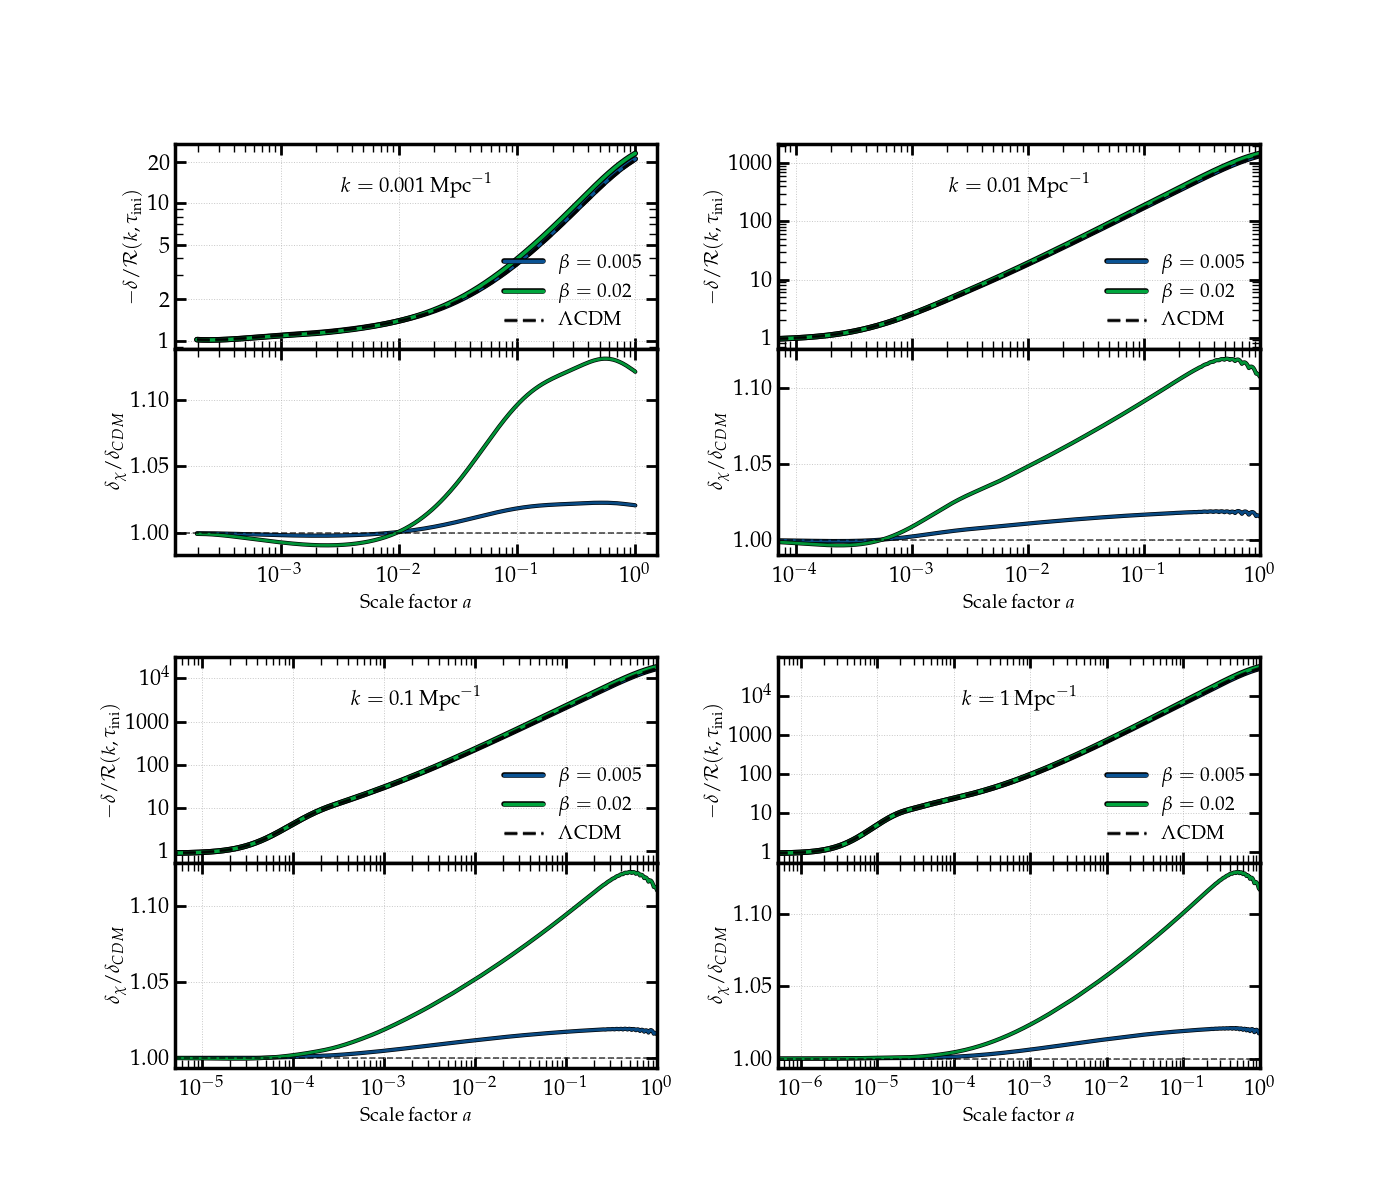

In [10]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.patheffects as pe


ks = k_values  # Example k values

fig = plt.figure(figsize=(14, 12))
outer = GridSpec(2, 2, wspace=0.25, hspace=0.25)

for idx, k in enumerate(ks):
    row, col = divmod(idx, 2)
    inner = GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[idx], height_ratios=[2, 2], hspace=0.0)

    ax1 = fig.add_subplot(inner[0])
    ax2 = fig.add_subplot(inner[1], sharex=ax1)

    # Interpolation function for LCDM
    interp_lcdm = interp1d(a_lcdm[k], delta_cdm_lcdm[k], kind='linear', bounds_error=False, fill_value='extrapolate')

    for beta in beta_lrm:
        # Plot delta
        ax1.loglog(a[beta, k], -delta_cdm[beta, k], 
            label=rf'$\beta = {beta}$',
            linewidth=2.5, path_effects=[pe.withStroke(linewidth=4, foreground='black')], alpha=0.9
        )
        
        # Interpolate LCDM delta
        delta_lcdm_interp = interp_lcdm(a[beta, k])
        ratio = delta_cdm[beta, k] / delta_lcdm_interp
        
        # Plot ratio
        ax2.semilogx(a[beta, k], ratio, 
            label=rf'$\beta = {beta}$',
            linewidth=2.0, path_effects=[pe.withStroke(linewidth=3, foreground='black')], alpha=0.8
        )
    
    ax1.loglog(a[beta, k], -delta_lcdm_interp, 
        label=rf'$\Lambda$CDM',
        linewidth=2.5, linestyle='--', alpha=0.8, color='black', path_effects=[pe.withStroke(linewidth=1, foreground='black')]
    )
    
    # LCDM lines
    #ax1.loglog(a_lcdm[k], np.abs(delta_g_lcdm[k]), color='black', linestyle='--', linewidth=2, label=r'$\delta_\gamma$')
    #ax1.loglog(a_lcdm[k], np.abs(delta_cdm_lcdm[k]), color='black', linestyle='-.', linewidth=2, label=r'$\delta_\mathrm{cdm}$')
    
    ax2.axhline(1, color='black', linestyle='--', linewidth=1.2, alpha=0.7)

    # Axes formatting
    # ax1.set_xlim(1e-3, 1)
    # ax2.set_xlim(1e-3, 1)
    # ax2.set_ylim(0.98, 1.16)

    ax1.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
    ax2.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)

    if idx == 0:
        #ax2.set_xlim(1e-5, 1)
        ax1.yaxis.set_major_locator(FixedLocator((1.0, 2.0, 5.0, 10, 20)))
        ax1.yaxis.set_major_formatter(FixedFormatter(['1', '2', '5', '10', '20']))
    if idx == 1:
        ax2.set_xlim(7e-5, 1)
        ax1.yaxis.set_major_locator(FixedLocator((1.0, 10.0, 100.0, 1000)))
        ax1.yaxis.set_major_formatter(FixedFormatter(['1', '10', '100', '1000']))
    if idx == 2:
        ax2.set_xlim(5e-6, 1)
        ax1.yaxis.set_major_locator(FixedLocator((1.0, 10.0, 100.0, 1000, 10000)))
        ax1.yaxis.set_major_formatter(FixedFormatter(['1', '10', '100', '1000', r'$10^4$']))
    if idx == 3:
        ax2.set_xlim(5e-7, 1)
        ax1.yaxis.set_major_locator(FixedLocator((1.0, 10.0, 100.0, 1000, 10000)))
        ax1.yaxis.set_major_formatter(FixedFormatter(['1', '10', '100', '1000', r'$10^4$']))

    #hide x-tick labels for ax1
    ax1.tick_params(axis='x', which='both', labelbottom=False)
    ax1.tick_params(axis='both', which='major', labelsize=16, length=8)
    ax2.tick_params(axis='both', which='major', labelsize=16, length=8)
    ax1.tick_params(axis='both', which='minor', labelsize=16, length=6)
    ax2.tick_params(axis='both', which='minor', labelsize=16, length=6)
    ax2.yaxis.set_major_locator(FixedLocator((1.0, 1.05, 1.1, 1.15)))
    #ax2.set_ylim(0.98, 1.16)

    ax2.set_xlabel(r'Scale factor $a$', fontsize=14)
    ax1.set_ylabel(r'$-\delta/\mathcal{R}(k, \tau_\mathrm{ini})$', fontsize=14)
    ax2.set_ylabel(r'$\delta_\chi/\delta_{CDM}$', fontsize=14)
    
    ax1.legend(fontsize=14, loc='lower right', frameon=False)
    ax1.text(0.5, 0.8, rf'$k = {k}\,\mathrm{{Mpc}}^{{-1}}$', fontsize=15, ha='center', va='center', transform=ax1.transAxes)
    #ax1.set_title(rf'$k = {k:.0e}\,\mathrm{{Mpc}}^{{-1}}$', fontsize=15)

# Shared legend
# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', fontsize=14, ncol=4, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('delta_cdm_2x2_nested.pdf', dpi=300, bbox_inches='tight')
plt.show()

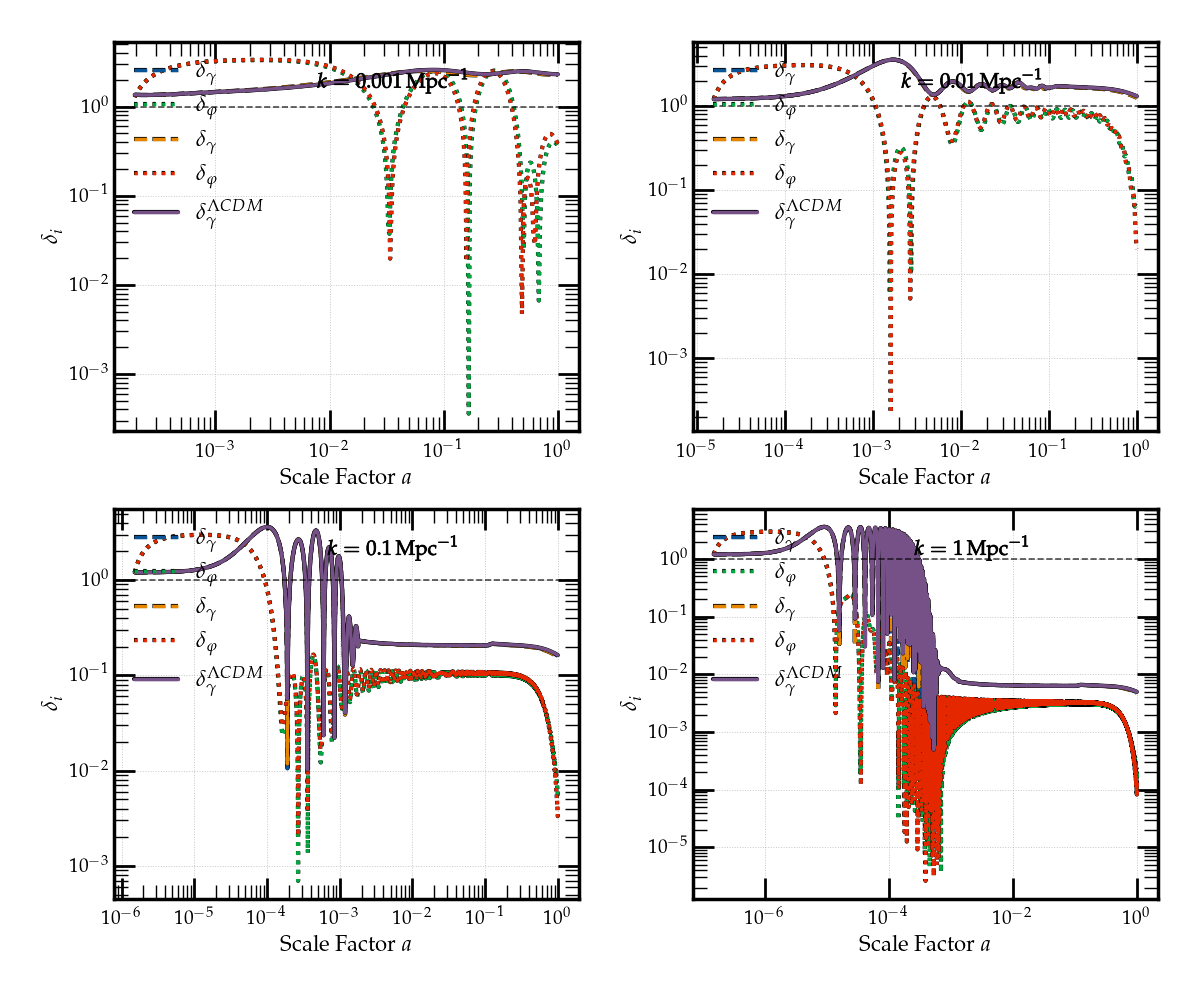

In [11]:
from scipy.interpolate import interp1d

# Set up figure
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=False)
axs = axs.flatten()

for i, k in enumerate(k_values):
    for beta in beta_lrm:
        # Plot
        axs[i].loglog(
            a[beta, k], 
            np.abs(delta_g[beta, k]),
            label=rf'$\delta_\gamma$', 
            linewidth=2.5,
            linestyle='--',
            path_effects=[pe.withStroke(linewidth=3, foreground='black')],
            alpha=0.9
        )
        
        axs[i].loglog(
            a[beta, k], 
            np.abs(delta_scf[beta, k]),
            label=rf'$\delta_\varphi$', 
            linewidth=2.5,
            linestyle=':',
            path_effects=[pe.withStroke(linewidth=3, foreground='black')],
            alpha=0.9
        )
        
    axs[i].loglog(
            a_lcdm[k], 
            np.abs(delta_g_lcdm[k]),
            label=rf'$\delta_\gamma^{{\Lambda CDM}}$', 
            linewidth=2.5,
            path_effects=[pe.withStroke(linewidth=3, foreground='black')],
            alpha=0.9
        )

for i, ax in enumerate(axs):
    ax.set_ylabel(r'$\delta_i$', fontsize=16)
    ax.set_xlabel(r'Scale Factor $a$', fontsize=16)
    ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=1.2, alpha=0.7)  # reference line at 1 (for ratios)
    #ax.set_xlim(1, 4000)
    ax.text(0.6, 0.9, rf'$k = {k_values[i]}\,\mathrm{{Mpc}}^{{-1}}$', fontsize=15, ha='center', va='center', transform=ax.transAxes, 
            path_effects=[pe.withStroke(linewidth=0.5, foreground='black')])
    ax.legend(fontsize=16, loc='upper left', frameon=False)
    # if i == 2 or i == 3:
    #     ax.set_xlim(1e-6, 1e-4)
    #     ax.set_ylim(0.998, 1.001)

# # X-axis label only on bottom plot
# axs[-1].set_xlabel(r'$1+z$', fontsize=18)
fig.savefig('delta_m.pdf', dpi=300, bbox_inches='tight')

# Layout adjustments
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

plt.show()

# Save the figure
#fig.savefig('beta_lrm_comparison.pdf', dpi=300, bbox_inches='tight')

79771 [0.99918288 0.99918308 0.99918327 0.99918521 0.99918715 0.99918908
 0.9991999  0.99921071 0.99922152 0.99923234 0.99926877 0.99930521
 0.99934164 0.99937807 0.99959395 0.99980977 1.00002556 1.00024129
 1.00068253 1.00112358]
77368 [0.99918121 0.9991814  0.99918159 0.99918353 0.99918547 0.9991874
 0.99919822 0.99920903 0.99921985 0.99923066 0.9992671  0.99930353
 0.99933996 0.99937639 0.99959227 0.9998081  1.00002388 1.00023961
 1.00068085 1.0011219 ]


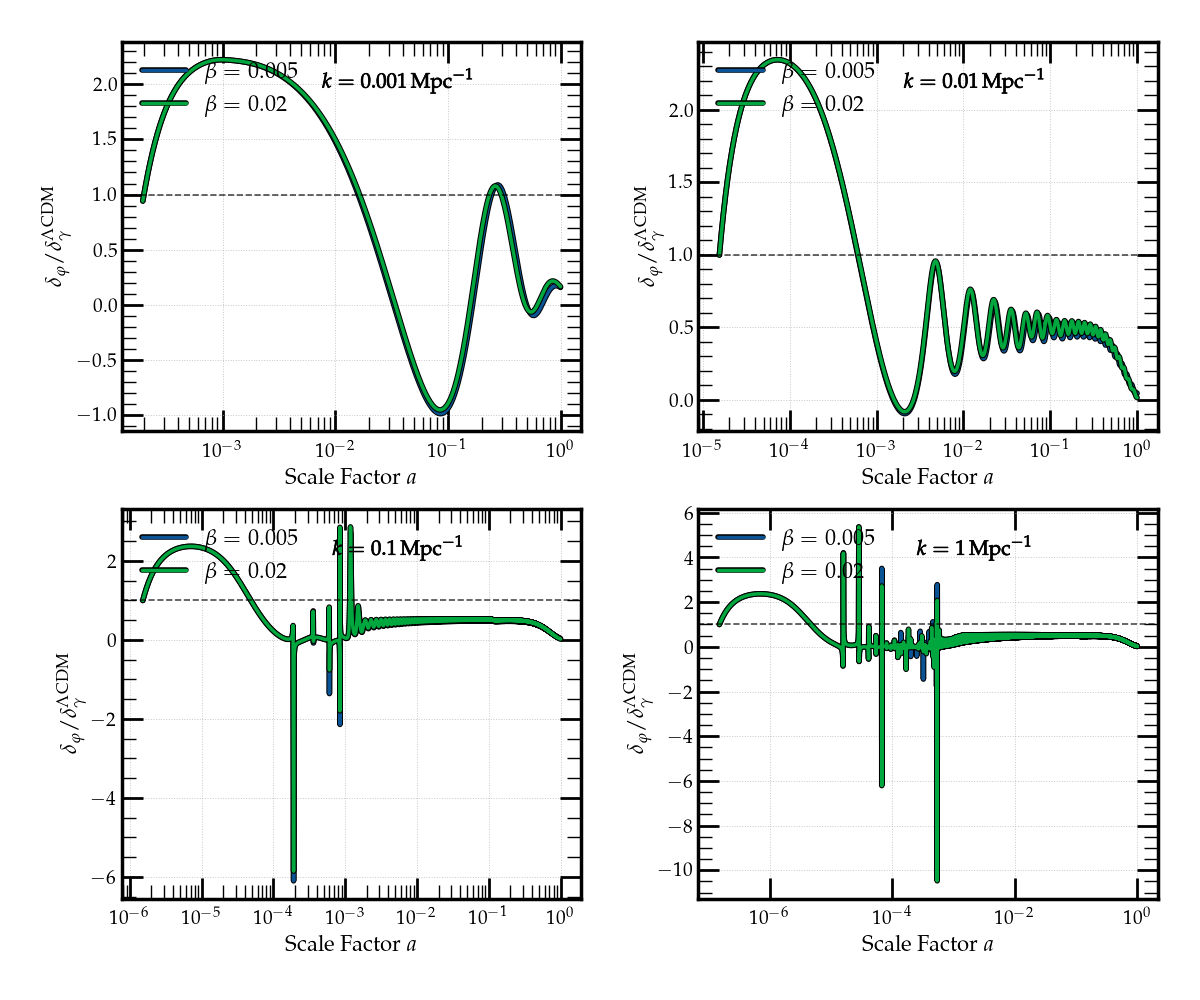

In [12]:
from scipy.interpolate import interp1d

# Set up figure
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=False)
axs = axs.flatten()

for i, k in enumerate(k_values):
    for beta in beta_lrm:
        
        # Interpolate LCDM delta onto a[beta] grid
        interp_lcdm = interp1d(a_lcdm[k], delta_g_lcdm[k], kind='linear', bounds_error=False, fill_value='extrapolate')
        delta_g_interp = interp_lcdm(a[beta, k])
        
        # Compute the ratio
        ratio = (delta_scf[beta, k]) / (delta_g[beta, k])
        if k == 1:
            print(len(ratio), ratio[:20])
        
        # Plot
        axs[i].semilogx(
            a[beta, k], 
            ratio, 
            label=rf'$\beta = {beta}$', 
            linewidth=2.5,
            path_effects=[pe.withStroke(linewidth=4, foreground='black')],
            alpha=0.9
        )

for i, ax in enumerate(axs):
    ax.set_ylabel(r'$\delta_\varphi/\delta_\gamma^{\Lambda\mathrm{CDM}}$', fontsize=16)
    ax.set_xlabel(r'Scale Factor $a$', fontsize=16)
    ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=1.2, alpha=0.7)  # reference line at 1 (for ratios)
    #ax.set_xlim(1, 4000)
    ax.text(0.6, 0.9, rf'$k = {k_values[i]}\,\mathrm{{Mpc}}^{{-1}}$', fontsize=15, ha='center', va='center', transform=ax.transAxes, 
            path_effects=[pe.withStroke(linewidth=0.5, foreground='black')])
    ax.legend(fontsize=16, loc='upper left', frameon=False)
    # if i == 2 or i == 3:
    #     ax.set_xlim(1e-6, 1e-4)
    #     ax.set_ylim(0.998, 1.001)

# # X-axis label only on bottom plot
# axs[-1].set_xlabel(r'$1+z$', fontsize=18)
fig.savefig('delta_m.pdf', dpi=300, bbox_inches='tight')

# Layout adjustments
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

plt.show()

# Save the figure
#fig.savefig('beta_lrm_comparison.pdf', dpi=300, bbox_inches='tight')

79771 [1.00008531 1.00008531 1.00008531 1.00008531 1.00008531 1.00008531
 1.00008531 1.00008531 1.00008531 1.00008531 1.00008531 1.00008531
 1.00008531 1.00008531 1.00008531 1.00008531 1.00008531 1.00008531
 1.00008531 1.00008531]
77368 [1.00008531 1.00008531 1.00008531 1.00008531 1.00008531 1.00008531
 1.00008531 1.00008531 1.00008531 1.00008531 1.00008531 1.00008531
 1.00008531 1.00008531 1.00008531 1.00008531 1.00008531 1.00008531
 1.00008531 1.00008531]


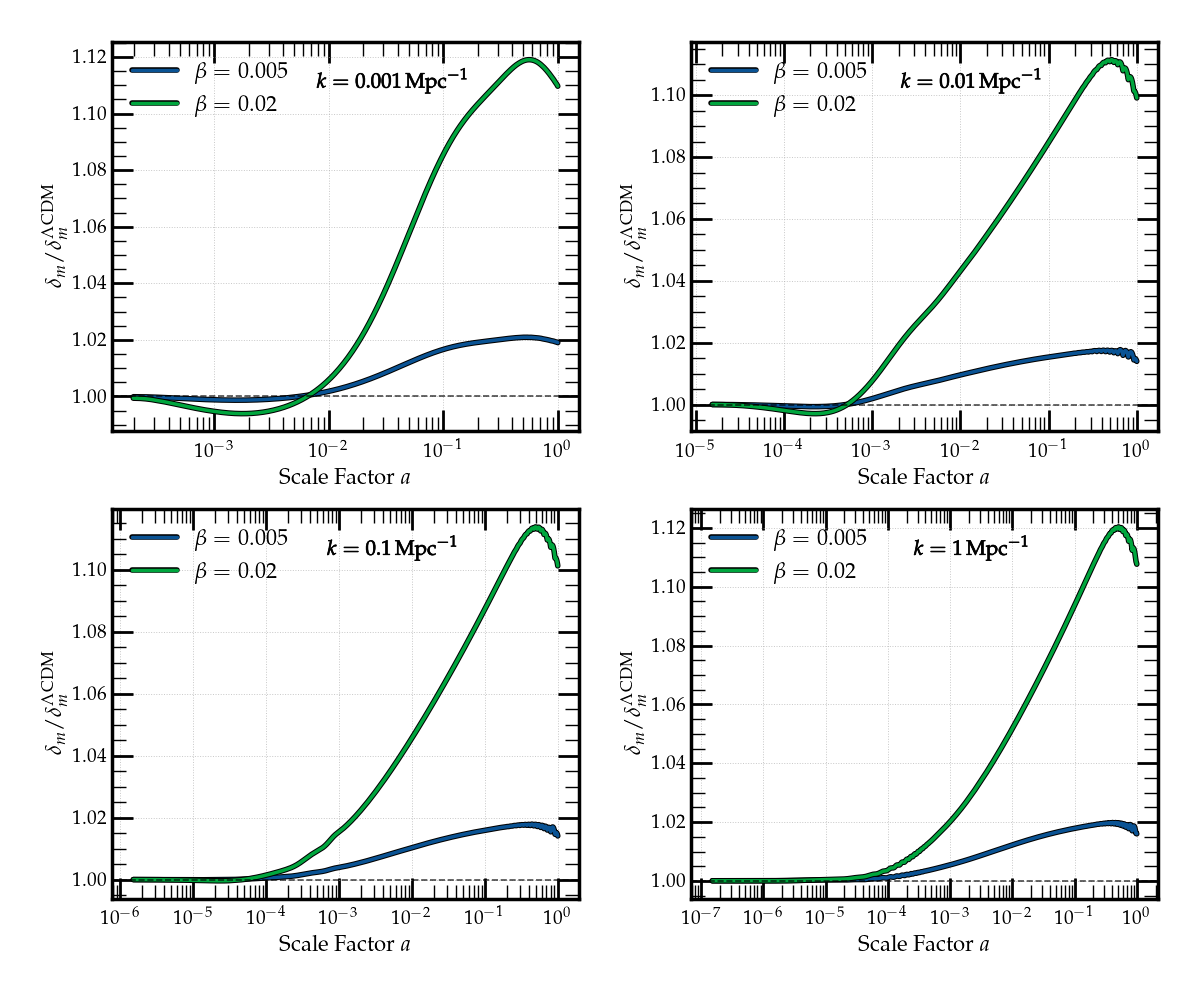

In [13]:
from scipy.interpolate import interp1d

# Set up figure
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=False)
axs = axs.flatten()

for i, k in enumerate(k_values):
    for beta in beta_lrm:
        
        # Interpolate LCDM delta onto a[beta] grid
        interp_lcdm = interp1d(a_lcdm[k], delta_m_lcdm[k], kind='linear', bounds_error=False, fill_value='extrapolate')
        delta_m_interp = interp_lcdm(a[beta, k])
        
        # Compute the ratio
        ratio = (delta_m[beta, k]) / delta_m_interp 
        if k == 1:
            print(len(ratio), ratio[:20])
        
        # Plot
        axs[i].semilogx(
            a[beta, k], 
            ratio, 
            label=rf'$\beta = {beta}$', 
            linewidth=2.5,
            path_effects=[pe.withStroke(linewidth=4, foreground='black')],
            alpha=0.9
        )

for i, ax in enumerate(axs):
    ax.set_ylabel(r'$\delta_m/\delta_m^{\Lambda\mathrm{CDM}}$', fontsize=16)
    ax.set_xlabel(r'Scale Factor $a$', fontsize=16)
    ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=1.2, alpha=0.7)  # reference line at 1 (for ratios)
    #ax.set_xlim(1, 4000)
    ax.text(0.6, 0.9, rf'$k = {k_values[i]}\,\mathrm{{Mpc}}^{{-1}}$', fontsize=15, ha='center', va='center', transform=ax.transAxes, 
            path_effects=[pe.withStroke(linewidth=0.5, foreground='black')])
    ax.legend(fontsize=16, loc='upper left', frameon=False)
    # if i == 2 or i == 3:
    #     ax.set_xlim(1e-6, 1e-4)
    #     ax.set_ylim(0.998, 1.001)

# # X-axis label only on bottom plot
# axs[-1].set_xlabel(r'$1+z$', fontsize=18)
fig.savefig('delta_m.pdf', dpi=300, bbox_inches='tight')

# Layout adjustments
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

plt.show()

# Save the figure
#fig.savefig('beta_lrm_comparison.pdf', dpi=300, bbox_inches='tight')

1050.1124208922784


/tmp/ipykernel_80844/313310080.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


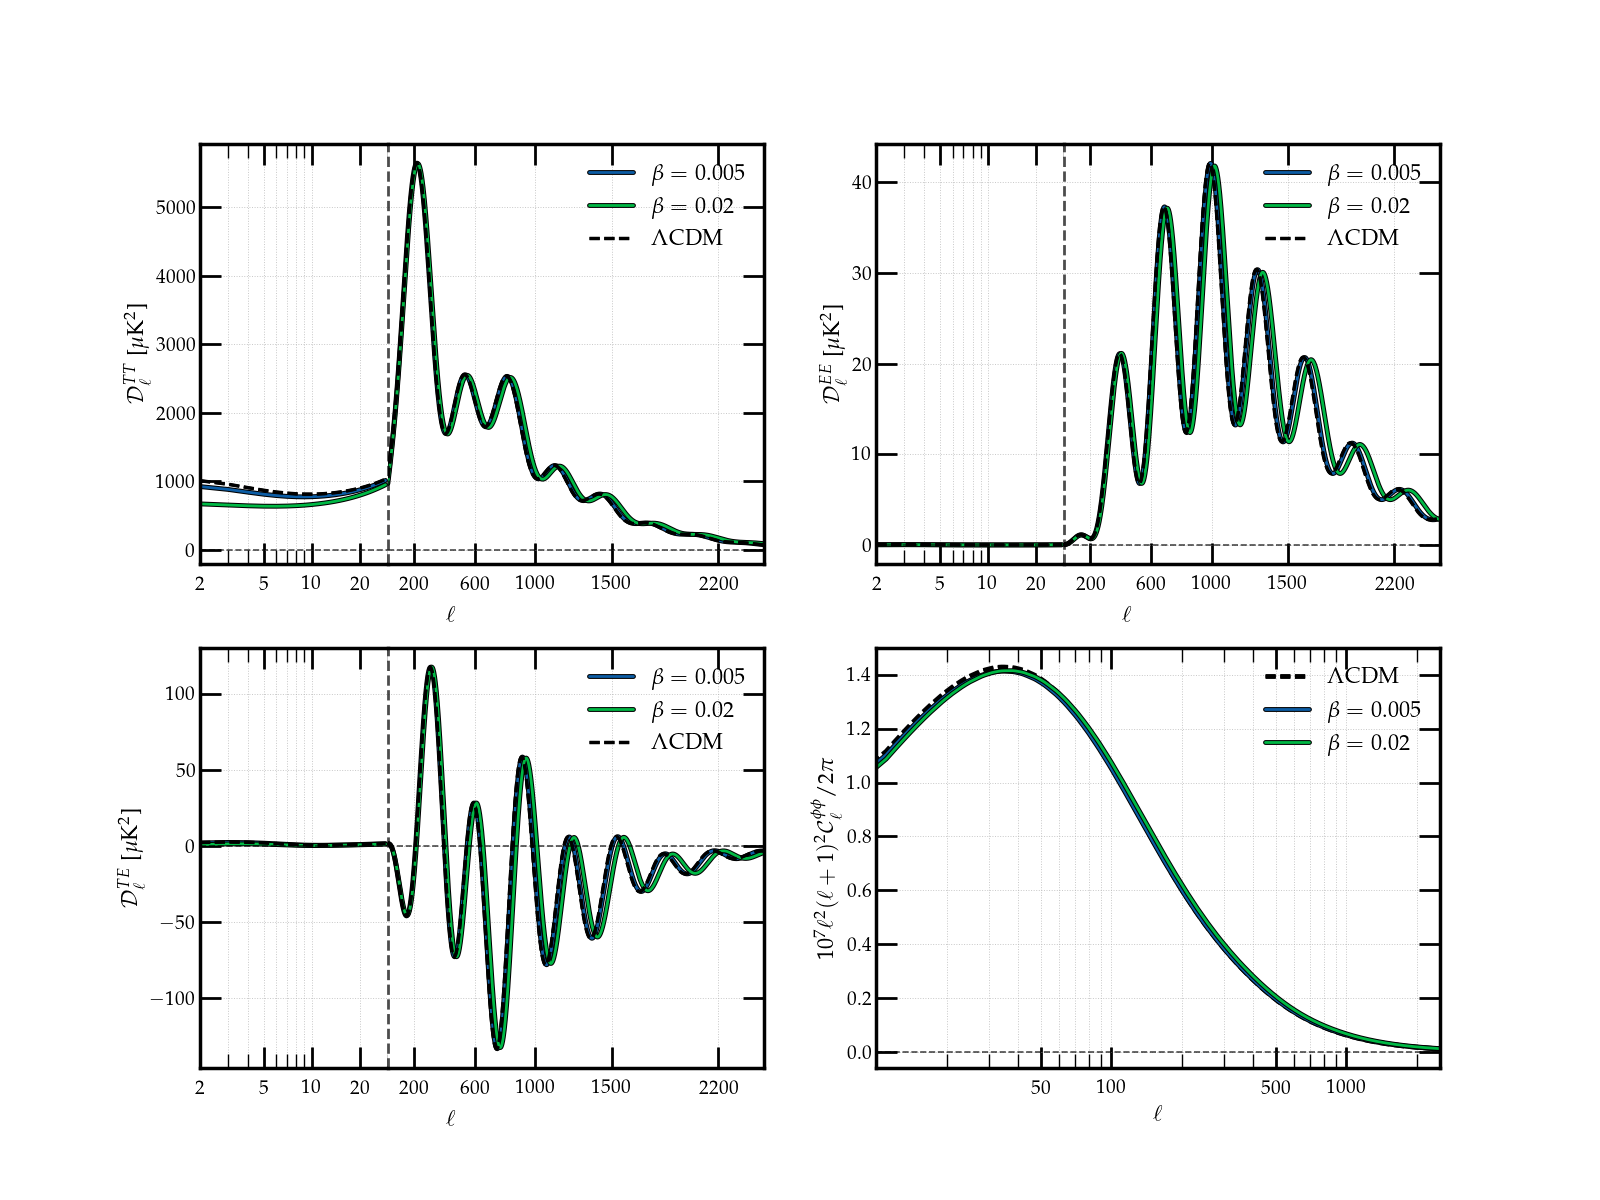

In [14]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter

### Plot the power spectra with split-axis approach
T0 = 2.7255  # CMB temperature in K

# Create figure with custom layout
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], wspace=0.2, hspace=0.2)

# Subplot configurations
subplot_configs = [
    (0, 'TT', clTT, r'$\mathcal{D}_\ell^{TT}$ [$\mu$K$^2$]', lambda cl, ell: cl*ell*(ell+1)/(2*np.pi)*1e12*T0**2),
    (1, 'EE', clEE, r'$\mathcal{D}_\ell^{EE}$ [$\mu$K$^2$]', lambda cl, ell: cl*ell*(ell+1)/(2*np.pi)*1e12*T0**2),
    (2, 'TE', clTE, r'$\mathcal{D}_\ell^{TE}$ [$\mu$K$^2$]', lambda cl, ell: cl*ell*(ell+1)/(2*np.pi)*1e12*T0**2),
    (3, 'PP', clPP, r'$10^{7}\ell^2(\ell+1)^2\mathcal{C}_\ell^{\phi\phi}/2\pi$', lambda cl, ell: cl*(ell*(ell+1))**2/(2*np.pi)*1e7)
]

# Custom plotting function for split-axis plots
def create_split_axis_subplot(fig, gs, row_col, ell, cl, label_func, ylabel, is_pp=False):
    # Create subplot grid
    if is_pp:
        # PP plot uses standard log scale
        ax = fig.add_subplot(gs[row_col])
        ax.set_xscale('log')
        ax.set_xlim(10, 2500)
        ax_log = ax
        ax.plot(ll_lcdm, clPP_lcdm*(ll_lcdm*(ll_lcdm+1))**2/(2*np.pi)*1e7, linewidth=2, label= rf'$\Lambda$CDM', ls='--', color = 'black', 
                    path_effects=[pe.withStroke(linewidth=3.5, foreground='black')])
        for beta in beta_lrm:
            ax.plot(ell[beta], cl[beta]*(ell[beta]*(ell[beta]+1))**2/(2*np.pi)*1e7, linewidth=2, label= rf'$\beta = {beta}$', 
                    path_effects=[pe.withStroke(linewidth=3.5, foreground='black')])
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1.2, alpha=0.7)
        ax.grid(which='both', linestyle=':', linewidth=0.7, alpha=0.7)
        ax.set_xlabel(r'$\ell$', fontsize=16)
        ax.set_ylabel(r'$10^{7}\ell^2(\ell+1)^2\mathcal{C}_\ell^{\phi\phi}/2\pi$', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xticks([50, 100, 500, 1000])
        ax.get_xaxis().set_major_formatter(ScalarFormatter())
        return ax
    
    # Create GridSpec for split-axis plots
    gs_sub = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[row_col], 
                                               width_ratios=[1, 2], wspace=0.0)
    
    # Left subplot (log scale)
    ax_log = fig.add_subplot(gs_sub[0])
    ax_log.set_xscale('log')
    ax_log.set_xlim(2, 30)
    
    # Right subplot (linear scale)
    ax_lin = fig.add_subplot(gs_sub[1], sharey=ax_log)
    ax_lin.set_xlim(30, 2500)
    
    # Remove spines between the two plots
    ax_log.spines['right'].set_visible(False)
    ax_lin.spines['left'].set_visible(False)
    ax_log.yaxis.tick_left()
    ax_lin.yaxis.tick_right()

    
    # Plot spectra for each beta
    for beta in beta_lrm:
        # Prepare data masks
        mask_log = ell[beta] < 30
        mask_lin = ell[beta] >= 30
        
        # Compute plotted values
        D_ell_log = label_func(cl[beta][mask_log], ell[beta][mask_log])
        D_ell_lin = label_func(cl[beta][mask_lin], ell[beta][mask_lin])
        
        # Line properties
        line_kwargs = {
            'linewidth': 2, 
            'path_effects': [pe.withStroke(linewidth=3.5, foreground='black')],
            'label': rf'$\beta = {beta}$'
        }
        
        # Plot on both axes
        ax_log.plot(ell[beta][mask_log], D_ell_log, **line_kwargs)
        ax_lin.plot(ell[beta][mask_lin], D_ell_lin, **line_kwargs)
    if name == 'TT':
        ax_log.plot(ll_lcdm[mask_log], clTT_lcdm[mask_log]*ll_lcdm[mask_log]*(ll_lcdm[mask_log]+1)/(2*np.pi)*1e12*T0**2, 
                        linewidth=2, ls='--', color = 'black', 
                        path_effects=[pe.withStroke(linewidth=2.5, foreground='black')])
        ax_lin.plot(ll_lcdm[mask_lin], clTT_lcdm[mask_lin]*ll_lcdm[mask_lin]*(ll_lcdm[mask_lin]+1)/(2*np.pi)*1e12*T0**2, 
                        linewidth=2, label= rf'$\Lambda$CDM', ls='--', color = 'black', 
                        path_effects=[pe.withStroke(linewidth=2.5, foreground='black')])
        print((clTT_lcdm[mask_lin]*ll_lcdm[mask_lin]*(ll_lcdm[mask_lin]+1)/(2*np.pi)*1e12*T0**2)[0])
    if name == 'EE':
        ax_log.plot(ll_lcdm[mask_log], clEE_lcdm[mask_log]*ll_lcdm[mask_log]*(ll_lcdm[mask_log]+1)/(2*np.pi)*1e12*T0**2, 
                    linewidth=2, ls='--', color = 'black', 
                    path_effects=[pe.withStroke(linewidth=2.5, foreground='black')])
        ax_lin.plot(ll_lcdm[mask_lin], clEE_lcdm[mask_lin]*ll_lcdm[mask_lin]*(ll_lcdm[mask_lin]+1)/(2*np.pi)*1e12*T0**2, 
                        linewidth=2, label= rf'$\Lambda$CDM', ls='--', color = 'black', 
                        path_effects=[pe.withStroke(linewidth=2.5, foreground='black')])
    if name == 'TE':
            ax_log.plot(ll_lcdm[mask_log], clTE_lcdm[mask_log]*ll_lcdm[mask_log]*(ll_lcdm[mask_log]+1)/(2*np.pi)*1e12*T0**2, 
                        linewidth=2, ls='--', color = 'black', 
                        path_effects=[pe.withStroke(linewidth=2.5, foreground='black')])
            ax_lin.plot(ll_lcdm[mask_lin], clTE_lcdm[mask_lin]*ll_lcdm[mask_lin]*(ll_lcdm[mask_lin]+1)/(2*np.pi)*1e12*T0**2, 
                        linewidth=2, label= rf'$\Lambda$CDM', ls='--', color = 'black', 
                        path_effects=[pe.withStroke(linewidth=2.5, foreground='black')])
    
    # Formatting
    ax_log.set_ylabel(ylabel, fontsize=16)
    ax_lin.set_xlabel(r'$\ell$', fontsize=16)
    ax_lin.xaxis.set_label_coords(1/6, -0.1)
    for ax in [ax_log, ax_lin]:
        ax.grid(which='both', linestyle=':', linewidth=0.7, alpha=0.7)
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1.2, alpha=0.7)
        ax.axvline(x=30, color='black', linestyle='--', linewidth=2, alpha=0.7)
        ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Tick formatting
    ax_log.set_xticks([2, 5, 10, 20])
    ax_lin.set_xticks([200, 600, 1000, 1500, 2200])
    for ax in [ax_log, ax_lin]:
        ax.get_xaxis().set_major_formatter(ScalarFormatter())
    
    # Tick visibility
    ax_log.tick_params(labelleft=True, labelright=False)
    ax_lin.tick_params(labelleft=False, labelright=False)
    
    # Legend
    ax_lin.legend(fontsize=16, loc='upper right', frameon=False)
    
    return ax_log, ax_lin

# Create subplots
for (idx, name, cl_dict, ylabel, label_func) in subplot_configs:
    is_pp = (name == 'PP')
    if is_pp:
        # PP plot is different (standard log scale)
        ax = create_split_axis_subplot(fig, gs, idx, ll, cl_dict, label_func, ylabel, is_pp=True)
        ax.legend(fontsize=16, loc='upper right', frameon=False)
    else:
        # TT, EE, TE plots use split-axis
        create_split_axis_subplot(fig, gs, idx, ll, cl_dict, label_func, ylabel)
        
fig.savefig('power_spectra.pdf', dpi=300, bbox_inches='tight')


plt.tight_layout()
plt.show()

/tmp/ipykernel_80844/1123083616.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


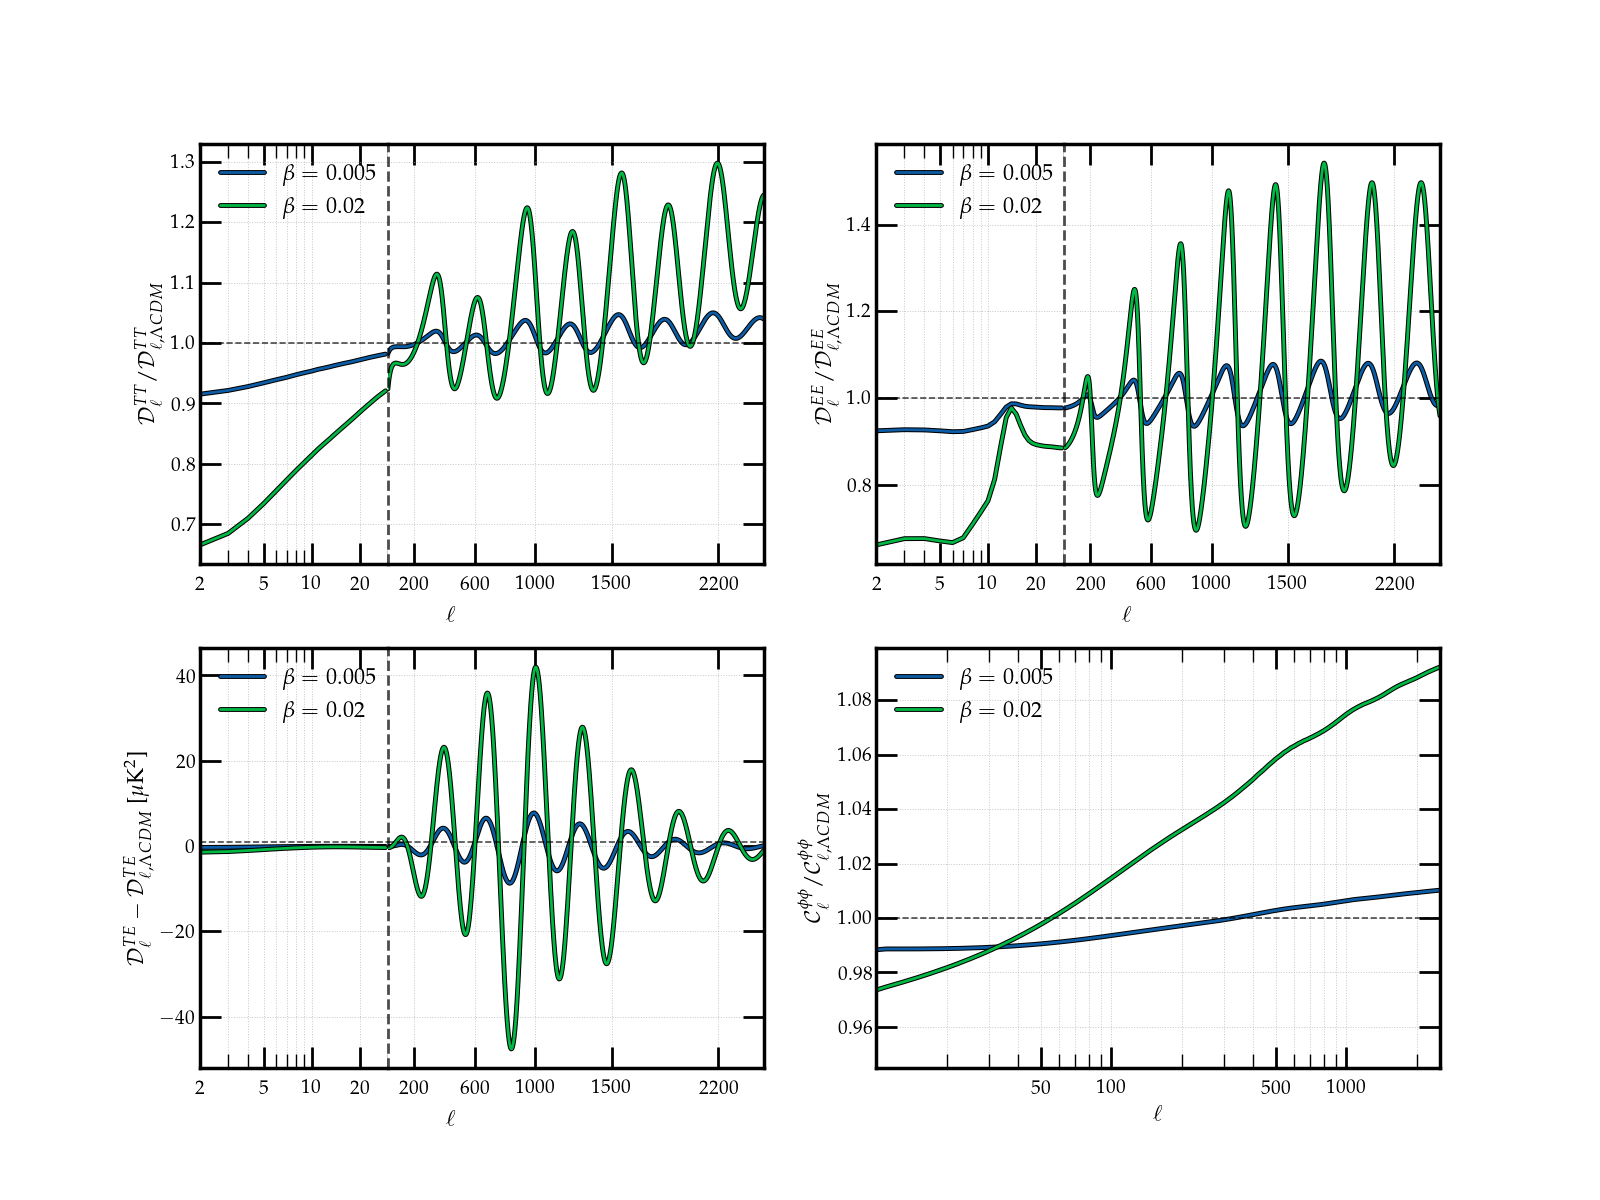

In [15]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter

### Plot the power spectra with split-axis approach
T0 = 2.7255  # CMB temperature in K

# Create figure with custom layout
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], wspace=0.2, hspace=0.2)

# Subplot configurations
subplot_configs = [
    (0, 'TT', clTT, clTT_lcdm, r'$\mathcal{D}_\ell^{TT}/\mathcal{D}_{\ell, \Lambda CDM}^{TT}$', lambda cl, clTT_lcdm: cl/clTT_lcdm),
    (1, 'EE', clEE, clEE_lcdm, r'$\mathcal{D}_\ell^{EE}/\mathcal{D}_{\ell, \Lambda CDM}^{EE}$', lambda cl, clEE_lcdm: cl/clEE_lcdm),
    (2, 'TE', clTE, clTE_lcdm, r'$\mathcal{D}_\ell^{TE}-\mathcal{D}_{\ell, \Lambda CDM}^{TE}$ [$\mu$K$^2$]', lambda cl, clTE_lcdm, ell: (cl-clTE_lcdm)*ell*(ell+1)/(2*np.pi)*1e12*T0**2),
    (3, 'PP', clPP, clPP_lcdm, r'$\mathcal{C}_\ell/\mathcal{C}_{\ell, \Lambda CDM}$', lambda cl, clPP_lcdm: cl/clPP_lcdm)
]

# Custom plotting function for split-axis plots
def create_split_axis_subplot(fig, gs, row_col, ell, cl, cl_lcdm, label_func, ylabel, is_pp=False):
    # Create subplot grid
    if is_pp:
        # PP plot uses standard log scale
        ax = fig.add_subplot(gs[row_col])
        ax.set_xscale('log')
        ax.set_xlim(10, 2500)
        ax_log = ax
        for beta in beta_lrm:
            ax.plot(ell[beta], cl[beta]/cl_lcdm, linewidth=2, label= rf'$\beta = {beta}$', 
                    path_effects=[pe.withStroke(linewidth=3.5, foreground='black')])
        ax.axhline(y=1, color='black', linestyle='--', linewidth=1.2, alpha=0.7)
        ax.grid(which='both', linestyle=':', linewidth=0.7, alpha=0.7)
        ax.set_xlabel(r'$\ell$', fontsize=16)
        ax.set_ylabel(r'$\mathcal{C}^{\phi\phi}_\ell/\mathcal{C}^{\phi\phi}_{\ell, \Lambda CDM}$', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xticks([50, 100, 500, 1000])
        ax.get_xaxis().set_major_formatter(ScalarFormatter())
        return ax
    
    # Create GridSpec for split-axis plots
    gs_sub = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[row_col], 
                                               width_ratios=[1, 2], wspace=0.0)
    
    # Left subplot (log scale)
    ax_log = fig.add_subplot(gs_sub[0])
    ax_log.set_xscale('log')
    ax_log.set_xlim(2, 30)
    
    # Right subplot (linear scale)
    ax_lin = fig.add_subplot(gs_sub[1], sharey=ax_log)
    ax_lin.set_xlim(30, 2500)
    
    # Remove spines between the two plots
    ax_log.spines['right'].set_visible(False)
    ax_lin.spines['left'].set_visible(False)
    ax_log.yaxis.tick_left()
    ax_lin.yaxis.tick_right()

    
    # Plot spectra for each beta
    for beta in beta_lrm:
        # Prepare data masks
        mask_log = ell[beta] < 30
        mask_lin = ell[beta] >= 30
        
        # Compute plotted values
        if idx == 2:
            D_ell_log = label_func(cl[beta][mask_log], cl_lcdm[mask_log], ell[beta][mask_log])
            D_ell_lin = label_func(cl[beta][mask_lin], cl_lcdm[mask_lin], ell[beta][mask_lin])
        else:
            D_ell_log = label_func(cl[beta][mask_log], cl_lcdm[mask_log])
            D_ell_lin = label_func(cl[beta][mask_lin], cl_lcdm[mask_lin])
        
        # Line properties
        line_kwargs = {
            'linewidth': 2, 
            'path_effects': [pe.withStroke(linewidth=3.5, foreground='black')],
            'label': rf'$\beta = {beta}$'
        }
        
        # Plot on both axes
        ax_log.plot(ell[beta][mask_log], D_ell_log, **line_kwargs)
        ax_lin.plot(ell[beta][mask_lin], D_ell_lin, **line_kwargs)
    
    # Formatting
    ax_log.set_ylabel(ylabel, fontsize=16)
    ax_lin.set_xlabel(r'$\ell$', fontsize=16)
    ax_lin.xaxis.set_label_coords(1/6, -0.1)
    for ax in [ax_log, ax_lin]:
        ax.grid(which='both', linestyle=':', linewidth=0.7, alpha=0.7)
        ax.axhline(y=1, color='black', linestyle='--', linewidth=1.2, alpha=0.7)
        ax.axvline(x=30, color='black', linestyle='--', linewidth=2, alpha=0.7)
        ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Tick formatting
    ax_log.set_xticks([2, 5, 10, 20])
    ax_lin.set_xticks([200, 600, 1000, 1500, 2200])
    for ax in [ax_log, ax_lin]:
        ax.get_xaxis().set_major_formatter(ScalarFormatter())
    
    # Tick visibility
    ax_log.tick_params(labelleft=True, labelright=False)
    ax_lin.tick_params(labelleft=False, labelright=False)
    
    # Legend
    ax_log.legend(fontsize=16, loc='upper left', frameon=False)
    
    return ax_log, ax_lin

# Create subplots
for (idx, name, cl_dict, cl_lcdm_dict, ylabel, label_func) in subplot_configs:
    is_pp = (name == 'PP')
    if is_pp:
        # PP plot is different (standard log scale)
        ax = create_split_axis_subplot(fig, gs, idx, ll, cl_dict, cl_lcdm_dict, label_func, ylabel, is_pp=True)
        ax.legend(fontsize=16, loc='upper left', frameon=False)
    else:
        # TT, EE, TE plots use split-axis
        create_split_axis_subplot(fig, gs, idx, ll, cl_dict, cl_lcdm_dict, label_func, ylabel)

fig.savefig('power_spectra_ratios.pdf', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()